In [1]:
import pandas as pd
import os
from datetime import datetime

stock_price_folder = "AAPL stock price data"

df_list = []
# Loops over all csv files in the stock price folder
for root, dir, files in os.walk(stock_price_folder):
    for file in files:

        print(file)

        # Adds the csv file to a data frame and adds that data frame to a list of data frames
        df_list.append(pd.read_csv(os.path.join(root, file)))

# Combines all the data frames into one
df_aapl = pd.concat(df_list)
df_aapl.head()

Download Data - STOCK_US_XNAS_AAPL (5).csv
Download Data - STOCK_US_XNAS_AAPL.csv
Download Data - STOCK_US_XNAS_AAPL (4).csv
Download Data - STOCK_US_XNAS_AAPL (3).csv
Download Data - STOCK_US_XNAS_AAPL (2).csv
Download Data - STOCK_US_XNAS_AAPL (1).csv


,Date,Open,High,Low,Close,Volume
0,01/26/2024,194.27,194.76,191.94,192.42,"44,594,008"
1,01/25/2024,195.22,196.27,193.11,194.17,"54,822,129"
2,01/24/2024,195.42,196.38,194.34,194.50,"53,631,320"
3,01/23/2024,195.02,195.75,193.83,195.18,"42,355,594"
4,01/22/2024,192.30,195.33,192.26,193.89,"60,133,848"


In [2]:
# Converts the text in the date column to datetime and sorts by date values, since the csv files may not have been loaded in order. 
df_aapl['Date'] = df_aapl['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))
df_aapl = df_aapl.sort_values("Date").reset_index(drop=True)

In [3]:
from datetime import time

# Takes only close and volume from stock price data and change time to datetime object at 4 pm each day (market closing time)
df_aapl = df_aapl.drop(columns=["Open", "High", "Low", "Volume"])
df_aapl["Date"] = df_aapl["Date"].apply(lambda x: datetime.combine(x, time(16, 0)))
df_aapl = df_aapl.rename(columns={"Date":"Datetime"})
df_aapl.head()

,Datetime,Close
0,2019-01-02 16:00:00,39.48
1,2019-01-03 16:00:00,35.55
2,2019-01-04 16:00:00,37.07
3,2019-01-07 16:00:00,36.98
4,2019-01-08 16:00:00,37.69


In [4]:
df_headlines = pd.read_csv("headlines_w_sentiment.csv")
df_headlines.head()

,Date,Time,Source,Headline,Symbol,Company,Positive,Negative,Neutral
0,02/15/2024,6:34AM,IH Market News,Cisco Systems Stock Drops 5% Following Restruc...,NASDAQ:AAPL,Apple Inc,0.012263,0.910677,0.077060
1,02/05/2024,9:00AM,Business Wire,USHER’s Road to Halftime on Apple Music lets f...,NASDAQ:AAPL,Apple Inc,0.064723,0.016325,0.918952
2,02/02/2024,8:47AM,IH Market News,Apple Beats Q1 Revenue and Earnings Estimates ...,NASDAQ:AAPL,Apple Inc,0.037662,0.950361,0.011977
3,02/01/2024,4:30PM,Business Wire,Apple reports first quarter results,NASDAQ:AAPL,Apple Inc,0.036920,0.067719,0.895361
4,01/25/2024,1:55PM,Dow Jones News,"Apple Issues Changes to Operating System, App ...",NASDAQ:AAPL,Apple Inc,0.042882,0.044438,0.912681


In [5]:
df_headlines["Datetime"] = df_headlines[["Date", "Time"]].apply(lambda row: ",".join(row.values.astype(str)), axis=1)
df_headlines["Datetime"] = df_headlines["Datetime"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y,%I:%M%p"))
df_headlines = df_headlines.sort_values("Datetime").reset_index(drop=True)
df_headlines = df_headlines.drop(columns=["Date", "Time"])

df_headlines.head()

,Source,Headline,Symbol,Company,Positive,Negative,Neutral,Datetime
0,Business Wire,Letter from Tim Cook to Apple Investors,NASDAQ:AAPL,Apple Inc,0.043703,0.025441,0.930855,2019-01-02 16:32:00
1,Dow Jones News,Apple Revises Guidance,NASDAQ:AAPL,Apple Inc,0.031828,0.060277,0.907895,2019-01-02 17:03:00
2,Dow Jones News,Apple Sees 1Q Revenue Below Views -- Update,NASDAQ:AAPL,Apple Inc,0.037558,0.284685,0.677757,2019-01-02 17:06:00
3,Dow Jones News,Apple Sees 1Q Revenue Below Views on Weakness ...,NASDAQ:AAPL,Apple Inc,0.141699,0.764652,0.093650,2019-01-02 17:07:00
4,Dow Jones News,Apple Sees 1Q Revenue Below Views on Weakness ...,NASDAQ:AAPL,Apple Inc,0.101044,0.809128,0.089828,2019-01-02 17:12:00


In [6]:
from datetime import timedelta
import numpy as np
from scipy.stats import norm

n = 7
gaussian_curve = 1.0

# Gets sentiment values at time t by aggregating over last n days using gaussian weighted sum
def get_sentiment_at_time(t):
    prev_time = t - timedelta(days=n)
    relevant_headlines = df_headlines[(df_headlines["Datetime"] < t) & (df_headlines["Datetime"] > prev_time)].reset_index(drop=True)

    if(len(relevant_headlines) != 0):
        relevant_headlines["Weight"] = relevant_headlines["Datetime"].apply(lambda x: norm.pdf(gaussian_curve*(t - x).total_seconds()/(n*24*60*60)))
        pos_weighted_sum = (relevant_headlines["Positive"]*relevant_headlines["Weight"]).sum()
        neg_weighted_sum = (relevant_headlines["Negative"]*relevant_headlines["Weight"]).sum()
        neu_weighted_sum = (relevant_headlines["Neutral"]*relevant_headlines["Weight"]).sum()
    else:
        pos_weighted_sum = np.nan
        neg_weighted_sum = np.nan
        neu_weighted_sum = np.nan
    return pd.Series([pos_weighted_sum, neg_weighted_sum, neu_weighted_sum], index=["pos_sentiment", "neg_sentiment", "neu_sentiment"])

In [7]:
# Removing n days from beginning of stocks dataframe as we will be summing sentiments over previous n days
df_aapl = df_aapl[df_aapl["Datetime"] > (df_aapl["Datetime"][0] + timedelta(days=n-1))].reset_index(drop=True)

# Apply sentiment calculation function to each closing time in stocks dataframe and add as new columns
sentiment_values = df_aapl["Datetime"].apply(lambda t: get_sentiment_at_time(t))
df_aapl = pd.concat([df_aapl, sentiment_values], axis=1)

df_aapl.head()

,Datetime,Close,pos_sentiment,neg_sentiment,neu_sentiment
0,2019-01-09 16:00:00,38.33,1.100743,4.776493,4.185911
1,2019-01-10 16:00:00,38.45,0.896649,1.783277,2.562371
2,2019-01-11 16:00:00,38.07,0.659561,0.835429,1.937766
3,2019-01-14 16:00:00,37.50,0.482867,0.721617,1.269760
4,2019-01-15 16:00:00,38.27,0.401434,1.009139,1.148115


In [8]:
for index, row in df_aapl.iterrows():

    if pd.isnull(row["pos_sentiment"]):
        df_aapl.iloc[index, 2:5] = df_aapl.iloc[index-1, 2:5]

df_aapl.isna().sum()

Datetime         0
Close            0
pos_sentiment    0
neg_sentiment    0
neu_sentiment    0
dtype: int64

In [9]:
price_movement = []

# Loops though all price values except for final value and get difference between this value and the value in the next row
for i in range(len(df_aapl)-1):
    price_movement.append(df_aapl["Close"][i+1] - df_aapl["Close"][i])
    
# Drops final row where price change couldn't be calculated and adds price change column
df_aapl = df_aapl.drop(df_aapl.index[-1])
df_aapl["Price Movement"] = price_movement
df_aapl.head()

,Datetime,Close,pos_sentiment,neg_sentiment,neu_sentiment,Price Movement
0,2019-01-09 16:00:00,38.33,1.100743,4.776493,4.185911,0.12
1,2019-01-10 16:00:00,38.45,0.896649,1.783277,2.562371,-0.38
2,2019-01-11 16:00:00,38.07,0.659561,0.835429,1.937766,-0.57
3,2019-01-14 16:00:00,37.50,0.482867,0.721617,1.269760,0.77
4,2019-01-15 16:00:00,38.27,0.401434,1.009139,1.148115,0.47


Correlation value = -0.043193684733441075
Slope (Gradient) of the Regression Line: -0.18101406958213


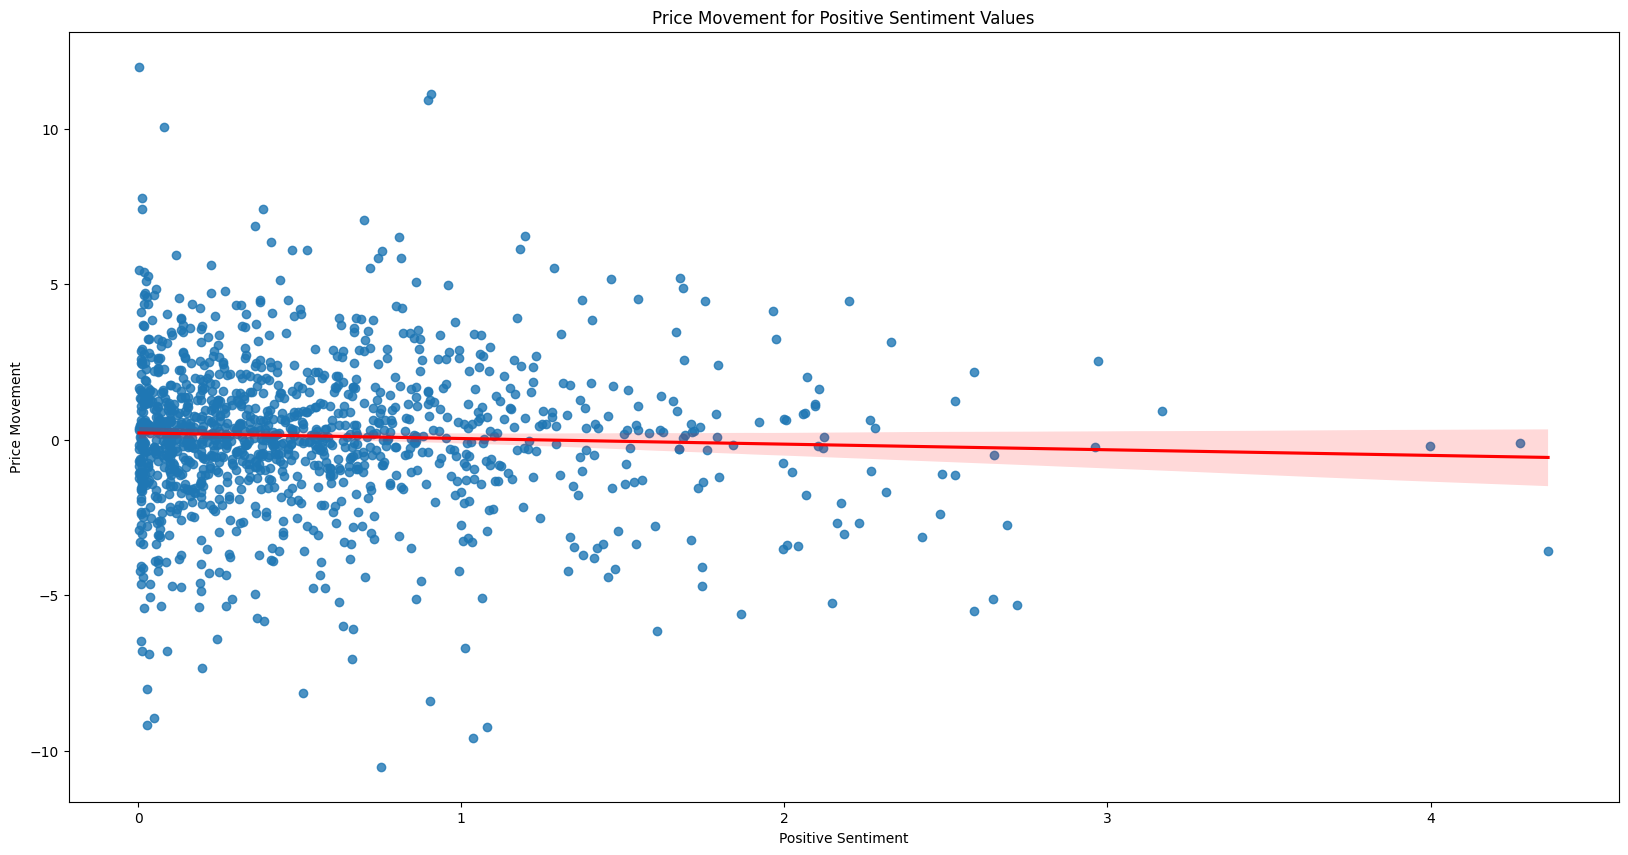

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

plt.figure(figsize=(20, 10))

regression_line = sns.regplot(x=df_aapl["pos_sentiment"], y=df_aapl["Price Movement"], scatter_kws={'marker': 'o'}, line_kws={'color': 'red'})
slope = linregress(df_aapl["pos_sentiment"], df_aapl["Price Movement"]).slope

# Print slope of regression line and correlation value 
print(f"Correlation value = {df_aapl['Price Movement'].corr(df_aapl['pos_sentiment'])}")
print(f"Slope (Gradient) of the Regression Line: {slope}")

plt.title('Price Movement for Positive Sentiment Values')
plt.xlabel('Positive Sentiment')
plt.ylabel('Price Movement')

plt.show()

Correlation value = -0.0095576511814255
Slope (Gradient) of the Regression Line: -0.034769062206148074


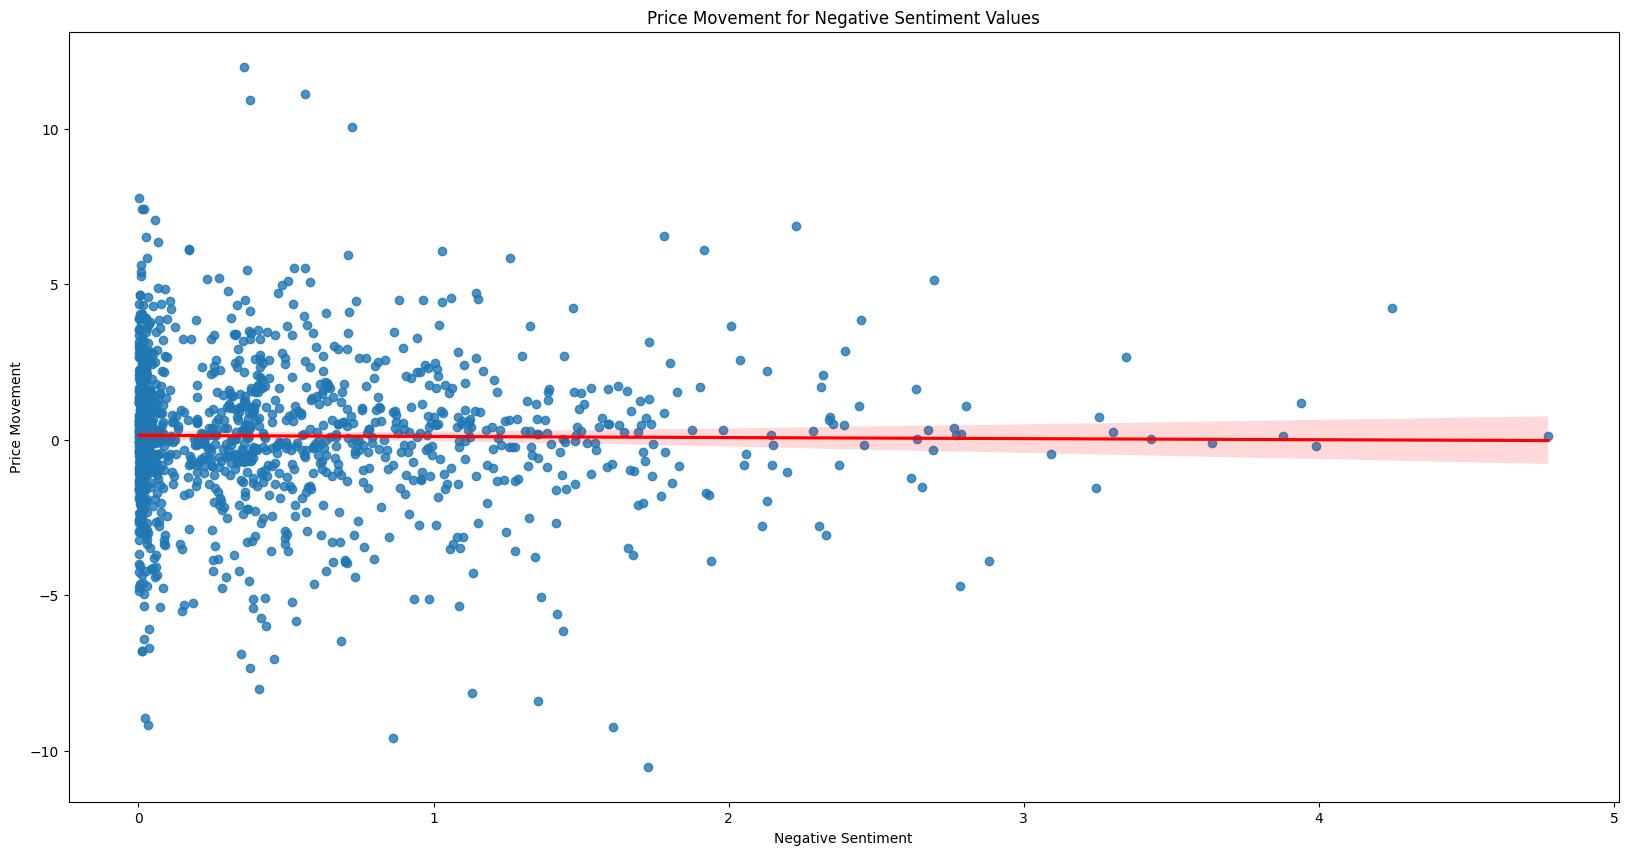

In [11]:
plt.figure(figsize=(20, 10))

regression_line = sns.regplot(x=df_aapl["neg_sentiment"], y=df_aapl["Price Movement"], scatter_kws={'marker': 'o'}, line_kws={'color': 'red'})
slope = linregress(df_aapl["neg_sentiment"], df_aapl["Price Movement"]).slope

# Print slope of regression line and correlation value 
print(f"Correlation value = {df_aapl['Price Movement'].corr(df_aapl['neg_sentiment'])}")
print(f"Slope (Gradient) of the Regression Line: {slope}")

plt.title('Price Movement for Negative Sentiment Values')
plt.xlabel('Negative Sentiment')
plt.ylabel('Price Movement')

plt.show()

In [ ]:
y_pred = 0
n_pred = 0


holding_vals = {"threshold":[], "holding":[]}

df_aapl_cutoff = df_aapl[(df_aapl["Datetime"] > datetime(2022, 1, 1)) & (df_aapl["Datetime"] < datetime(2023, 1, 1))]
for threshold in np.arange(0, 1, 0.01):
    holding = 1
    
    for index, row in df_aapl_cutoff.iterrows():
        #if(row["pos_sentiment"] > (0.2*max(df_aapl["pos_sentiment"]))):
        if(row["pos_sentiment"] > threshold):
            holding = holding*((row["Close"]+row["Price Change"])/row["Close"])

            if(row["Price Change"] > 0): y_pred += 1
            else: n_pred += 1
    
    holding_vals["threshold"].append(threshold)
    holding_vals["holding"].append(holding)

print(holding_vals)
print(max(holding_vals["holding"]))
print((df_aapl_cutoff["Close"].iloc[-1])/df_aapl_cutoff["Close"].iloc[0])
print(y_pred)
print(n_pred)
